<table>
    <tr>
        <td>
            <img src='./text_images/nvidia.png' width="400" height="225">
        </td>
        <td> & </td>
        <td>
            <img src='./text_images/udacity.png' width="700" height="225">
        </td>
    </tr>
</table>

# Deep Reinforcement Learning for Optimal Execution of Portfolio Transactions     

# Introduction

This notebook demonstrates how to use Deep Reinforcement Learning (DRL) for optimizing the execution of large portfolio transactions. We begin with a brief review of reinforcement learning and actor-critic methods.  Then, you will use an actor-critic method to generate optimal trading strategies that maximize profit when liquidating a block of shares. 

# Actor-Critic Methods

In reinforcement learning, an agent makes observations and takes actions within an environment, and in return it receives rewards. Its objective is to learn to act in a way that will maximize its expected long-term rewards. 

<br>
<figure>
  <img src = "./text_images/RL.png" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 1. - Reinforcement Learning.</figcaption>
</figure> 
<br>

There are several types of RL algorithms, and they can be divided into three groups:

- **Critic-Only**: Critic-Only methods, also known as Value-Based methods, first find the optimal value function and then derive an optimal policy from it. 


- **Actor-Only**: Actor-Only methods, also known as Policy-Based methods, search directly for the optimal policy in policy space. This is typically done by using a parameterized family of policies over which optimization procedures can be used directly. 


- **Actor-Critic**: Actor-Critic methods combine the advantages of actor-only and critic-only methods. In this method, the critic learns the value function and uses it to determine how the actor's policy parramerters should be changed. In this case, the actor brings the advantage of computing continuous actions without the need for optimization procedures on a value function, while the critic supplies the actor with knowledge of the performance. Actor-critic methods usually have good convergence properties, in contrast to critic-only methods.  The **Deep Deterministic Policy Gradients (DDPG)** algorithm is one example of an actor-critic method.

<br>
<figure>
  <img src = "./text_images/Actor-Critic.png" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 2. - Actor-Critic Reinforcement Learning.</figcaption>
</figure> 
<br>

In this notebook, we will use DDPG to determine the optimal execution of portfolio transactions. In other words, we will use the DDPG algorithm to solve the optimal liquidation problem. But before we can apply the DDPG algorithm we first need to formulate the optimal liquidation problem so that in can be solved using reinforcement learning. In the next section we will see how to do this. 

# Modeling Optimal Execution as a Reinforcement Learning Problem

As we learned in the previous lessons, the optimal liquidation problem is a minimization problem, *i.e.* we need to find the trading list that minimizes the implementation shortfall. In order to solve this problem through reinforcement learning, we need to restate the optimal liquidation problem in terms of **States**, **Actions**, and **Rewards**. Let's start by defining our States.

### States

The optimal liquidation problem entails that we sell all our shares within a given time frame. Therefore, our state vector must contain some information about the time remaining, or what is equivalent, the number trades remaning. We will use the latter and use the following features to define the state vector at time $t_k$:


$$
[r_{k-5},\, r_{k-4},\, r_{k-3},\, r_{k-2},\, r_{k-1},\, r_{k},\, m_{k},\, i_{k}]
$$

where:

- $r_{k} = \log\left(\frac{\tilde{S}_k}{\tilde{S}_{k-1}}\right)$ is the log-return at time $t_k$


- $m_{k} = \frac{N_k}{N}$ is the number of trades remaining at time $t_k$ normalized by the total number of trades.


- $i_{k} = \frac{x_k}{X}$ is the remaining number of shares at time $t_k$ normalized by the total number of shares.

The log-returns capture information about stock prices before time $t_k$, which can be used to detect possible price trends. The number of trades and shares remaining allow the agent to learn to sell all the shares within a given time frame. It is important to note that in real world trading scenarios, this state vector can hold many more variables. 

### Actions

Since the optimal liquidation problem only requires us to sell stocks, it is reasonable to define the action $a_k$ to be the number of shares to sell at time $t_{k}$. However, if we start with millions of stocks, intepreting the action directly as the number of shares to sell at each time step can lead to convergence problems, because, the agent will need to produce actions with very high values. Instead, we will interpret the action $a_k$ as a **percentage**. In this case, the actions produced by the agent will only need to be between 0 and 1. Using this interpretation, we can determine the number of shares to sell at each time step using:

$$
n_k = a_k \times x_k
$$

where $x_k$ is the number of shares remaining at time $t_k$.

### Rewards

Defining the rewards is trickier than defining states and actions, since the original problem is a minimization problem. One option is to use the difference between two consecutive utility functions. Remeber the utility function is given by:

$$
U(x) = E(x) + λ V(x)
$$

After each time step, we compute the utility using the equations for $E(x)$ and $V(x)$ from the Almgren and Chriss model for the remaining time and inventory while holding parameter λ constant. Denoting the optimal trading trajectory computed at time $t$ as $x^*_t$, we define the reward as: 

$$
R_{t} = {{U_t(x^*_t) - U_{t+1}(x^*_{t+1})}\over{U_t(x^*_t)}}
$$

Where we have normalized the difference to train the actor-critic model easier.

# Simulation Environment

In order to train our DDPG algorithm we will use a very simple simulated trading environment. This environment simulates stock prices that follow a discrete arithmetic random walk and that the permanent and temporary market impact functions are linear functions of the rate of trading, just like in the Almgren and Chriss model. This simple trading environment serves as a starting point to create more complex trading environments. You are encouraged to extend this simple trading environment by adding more complexity to simulte real world trading dynamics, such as book orders, network latencies, trading fees, etc... 

The simulated enviroment is contained in the **syntheticChrissAlmgren.py** module. You are encouraged to take a look it and modify its parameters as you wish. Let's take a look at the default parameters of our simulation environment. We have set the intial stock price to be $S_0 = 50$, and the total number of shares to sell to one million. This gives an initial portfolio value of $\$50$ Million dollars. We have also set the trader's risk aversion to $\lambda = 10^{-6}$.

The stock price will have 12\% annual volatility, a [bid-ask spread](https://www.investopedia.com/terms/b/bid-askspread.asp) of 1/8 and an average daily trading volume of 5 million shares. Assuming there are 250 trading days in a year, this gives a daily volatility in stock price of $0.12 / \sqrt{250} \approx 0.8\%$. We will use a liquiditation time of $T = 60$ days and we will set the number of trades $N = 60$. This means that $\tau=\frac{T}{N} = 1$ which means we will be making one trade per day. 

For the temporary cost function we will set the fixed cost of selling to be 1/2 of the bid-ask spread, $\epsilon = 1/16$. we will set $\eta$ such that for each one percent of the daily volume we trade, we incur a price impact equal to the bid-ask
spread. For example, trading at a rate of $5\%$ of the daily trading volume incurs a one-time cost on each trade of 5/8. Under this assumption we have $\eta =(1/8)/(0.01 \times 5 \times 10^6) = 2.5 \times 10^{-6}$.

For the permanent costs, a common rule of thumb is that price effects become significant when we sell $10\%$ of the daily volume. If we suppose that significant means that the price depression is one bid-ask spread, and that the effect is linear for smaller and larger trading rates, then we have $\gamma = (1/8)/(0.1 \times 5 \times 10^6) = 2.5 \times 10^{-7}$. 

The tables below summarize the default parameters of the simulation environment

In [1]:
import utils

# Get the default financial and AC Model parameters
financial_params, ac_params = utils.get_env_param()

In [2]:
financial_params

Annual Volatility:,12%,Bid-Ask Spread:,0.125
Daily Volatility:,0.8%,Daily Trading Volume:,"5,000,000"


In [3]:
ac_params

Total Number of Shares to Sell:,"1,000,000",Fixed Cost of Selling per Share:,$0.062
Starting Price per Share:,$50.00,Trader's Risk Aversion:,1e-06
Price Impact for Each 1% of Daily Volume Traded:,$2.5e-06,Permanent Impact Constant:,2.5e-07
Number of Days to Sell All the Shares:,60,Single Step Variance:,0.144
Number of Trades:,60,Time Interval between trades:,1.0


# Reinforcement Learning

In the code below we use DDPG to find a policy that can generate optimal trading trajectories that minimize implementation shortfall, and can be benchmarked against the Almgren and Chriss model. We will implement a typical reinforcement learning workflow to train the actor and critic using the simulation environment. We feed the states observed from our simulator to an agent. The Agent first predicts an action using the actor model and performs the action in the environment. Then, environment returns the reward and new state. This process continues for the given number of episodes. To get accurate results, you should run the code at least 10,000 episodes.

In [1]:
import numpy as np

import syntheticChrissAlmgren as sca
from ddpg_agent import Agent
from noise import OUNoise

from collections import deque

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def train_agent(env, agent, lqt, n_trades, tr, episodes):
    shortfall_hist = np.array([])
    shortfall_deque = deque(maxlen=100)
    total_rewards = np.array([])

    for episode in range(episodes): 
        total_reward = 0
        # Reset the environment
        cur_state = env.reset(seed=episode, liquid_time=lqt, num_trades=n_trades, lamb=tr)

        # Set the environment to make transactions
        env.start_transactions()

        for i in range(n_trades + 1):
            # Predict the best action for the current state  return [0,1]
            action = agent.act(cur_state, add_noise=True)
            
            # Action is performed and new state, reward, info are received
            new_state, reward, done, info = env.step(action)

            total_reward += reward
            
            # Current state, action, reward, new state are stored in the experience replay
            # Important fix, set action from [0,1] back to [-1,1], otherwise change agent actor to use sigmoid [0,1]
            action = 2.0 * action - 1.0
            agent.step(cur_state, action, reward, new_state, done)
            
            # Roll over new state
            cur_state = new_state

            if info.done:
                agent.reset()
                total_rewards = np.append(total_rewards, total_reward)
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                shortfall_deque.append(info.implementation_shortfall)
                break
        
        if (episode + 1) % 100 == 0:  # Print average shortfall over last 100 episodes
            print('\rEpisode [{}/{}]\tAverage Shortfall: ${:,.2f}'.format(episode + 1, episodes, np.mean(shortfall_deque)))        

    print('\nAverage Implementation Shortfall: ${:,.2f} \n'.format(np.mean(shortfall_hist)))
    return shortfall_hist, total_rewards

def plot_shortfall_hist(shortfall_hist):

    print('Average Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.mean()))
    print('Standard Deviation of the Implementation Shortfall: ${:,.2f}'.format(shortfall_hist.std()))

    plt.plot(shortfall_hist, 'cyan', label='')
    plt.xlim(0, len(shortfall_hist))
    ax = plt.gca()
    ax.set_facecolor('k')
    ax.set_xlabel('Episode', fontsize=15)
    ax.set_ylabel('Implementation Shortfall (US $)', fontsize=15)
    ax.axhline(np.mean(shortfall_hist), 0, 1, color='m', label='Average')
    yNumFmt = mticker.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(yNumFmt)
    plt.legend()
    plt.show()

def eval_agent(lq_time = 60, nm_trades = 60, tr_risk = 1e-6, trs = 100, agent=None):
    # Create simulation environment
    env = sca.MarketEnvironment()

    # Reset the enviroment
    env.reset(liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

    # Set the initial shortfall to zero
    shortfall_hist = np.array([])

    for episode in range(trs):
         # Reset the enviroment
        cur_state = env.reset(seed = episode, liquid_time = lq_time, num_trades = nm_trades, lamb = tr_risk)

        # set the environment to make transactions
        env.start_transactions()

        for i in range(nm_trades + 1):
            # Predict the best action without noise
            action = agent.act(cur_state, add_noise=False)
            new_state, _, _, info = env.step(action)
            # print(reward)

            # Roll over new state
            cur_state = new_state

            if info.done:
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                break
    
    plot_shortfall_hist(shortfall_hist)


In [2]:
# Create simulation environment
env = sca.MarketEnvironment()

action_size = env.action_space_dimension()
state_size = env.observation_space_dimension()

noise = OUNoise(action_size, seed=0)

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0, noise=noise)
# Set the liquidation time
lqt = 60
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr = 1e-6
# Set the number of episodes to run the simulation
episodes = 10000

# Train the agent and get the shortfall history
shortfall_hist, total_rewards = train_agent(env, agent, lqt, n_trades, tr, episodes)


Episode [100/10000]	Average Shortfall: $148,956.89
Episode [200/10000]	Average Shortfall: $474,824.67
Episode [300/10000]	Average Shortfall: $177,837.11
Episode [400/10000]	Average Shortfall: $242,628.66
Episode [500/10000]	Average Shortfall: $270,660.46
Episode [600/10000]	Average Shortfall: $205,553.74
Episode [700/10000]	Average Shortfall: $197,716.68
Episode [800/10000]	Average Shortfall: $405,199.71
Episode [900/10000]	Average Shortfall: $373,389.03
Episode [1000/10000]	Average Shortfall: $101,725.05
Episode [1100/10000]	Average Shortfall: $187,655.00
Episode [1200/10000]	Average Shortfall: $306,254.38
Episode [1300/10000]	Average Shortfall: $213,891.28
Episode [1400/10000]	Average Shortfall: $256,085.81
Episode [1500/10000]	Average Shortfall: $419,320.08
Episode [1600/10000]	Average Shortfall: $260,355.56
Episode [1700/10000]	Average Shortfall: $397,078.43
Episode [1800/10000]	Average Shortfall: $292,363.21
Episode [1900/10000]	Average Shortfall: $284,072.26
Episode [2000/10000]	

Average Implementation Shortfall: $254,057.02
Standard Deviation of the Implementation Shortfall: $1,106,346.45


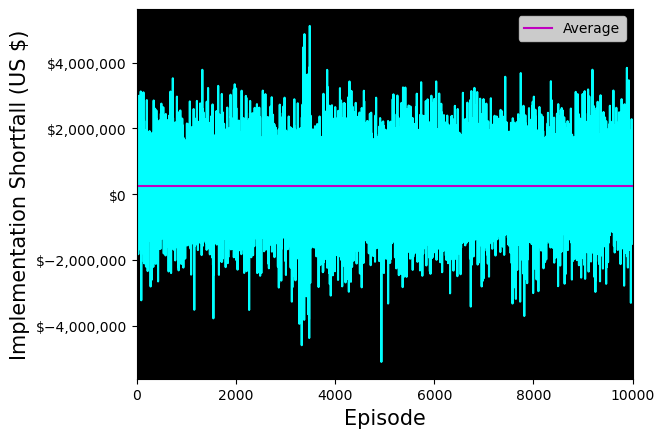

In [3]:
plot_shortfall_hist(shortfall_hist)
# plt.plot(total_rewards, 'cyan', label='Total Rewards')
# eval_agent(trs=1000, agent=agent)

## TD3 Algorithm 

In [ ]:
from td3_agent import TD3Agent

# Create simulation environment
env = sca.MarketEnvironment()

action_size = env.action_space_dimension()
state_size = env.observation_space_dimension()

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = TD3Agent(state_size=state_size, action_size=action_size, random_seed=0)

# Set the liquidation time
lqt = 60
# Set the number of trades
n_trades = 60
# Set trader's risk aversion
tr = 1e-6
# Set the number of episodes to run the simulation
episodes = 10000

# Train the agent and get the shortfall history
shortfall_hist, total_rewards = train_agent(env, agent, lqt, n_trades, tr, episodes)


Episode [100/10000]	Average Shortfall: $169,032.61
Episode [200/10000]	Average Shortfall: $437,002.07
Episode [300/10000]	Average Shortfall: $157,689.18
Episode [400/10000]	Average Shortfall: $231,893.00
Episode [500/10000]	Average Shortfall: $162,505.92
Episode [600/10000]	Average Shortfall: $275,171.84
Episode [700/10000]	Average Shortfall: $411,900.26
Episode [800/10000]	Average Shortfall: $248,120.82
Episode [900/10000]	Average Shortfall: $175,982.31
Episode [1000/10000]	Average Shortfall: $277,207.28
Episode [1100/10000]	Average Shortfall: $345,354.05
Episode [1200/10000]	Average Shortfall: $324,849.88
Episode [1300/10000]	Average Shortfall: $234,737.66
Episode [1400/10000]	Average Shortfall: $307,109.39
Episode [1500/10000]	Average Shortfall: $474,640.60
Episode [1600/10000]	Average Shortfall: $276,485.38


Average Implementation Shortfall: $237,401.31
Standard Deviation of the Implementation Shortfall: $1,213,301.08


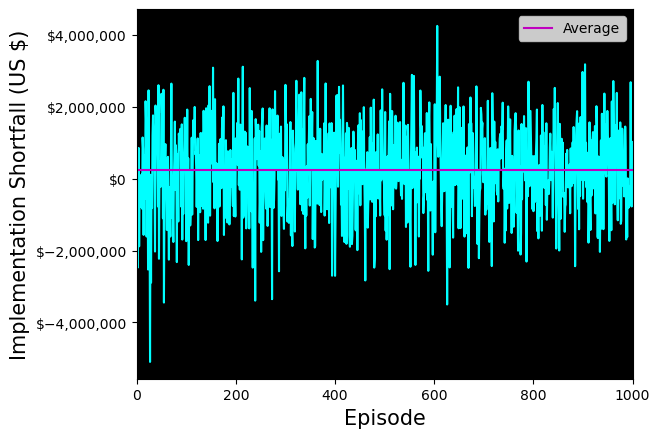

Average Implementation Shortfall: $273,480.27
Standard Deviation of the Implementation Shortfall: $1,077,574.18


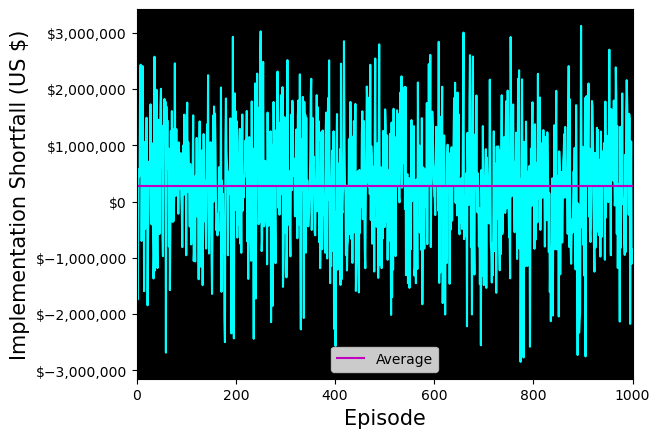

In [3]:
plot_shortfall_hist(shortfall_hist)
# plt.plot(total_rewards, 'cyan', label='Total Rewards')
eval_agent(trs=1000, agent=agent)

#### Normal Noise DDPG

In [4]:
from noise import NormalActionNoise
# Create simulation environment
env = sca.MarketEnvironment()

action_size = env.action_space_dimension()
state_size = env.observation_space_dimension()
random_seed = 0

noise = NormalActionNoise(action_size, seed=random_seed, scale=0.2)
# Initialize Feed-forward DNNs for Actor and Critic models. 
agent_normal = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, noise=noise)

# Set the parameters
lqt = 60
n_trades = 60
tr = 1e-6
episodes = 10000

# Train the agent and get the shortfall history
shortfall_hist_normal, total_rewards = train_agent(env, agent_normal, lqt, n_trades, tr, episodes)

Episode [100/1000]	Average Shortfall: $178,075.08
Episode [200/1000]	Average Shortfall: $512,961.29
Episode [300/1000]	Average Shortfall: $365,540.69
Episode [400/1000]	Average Shortfall: $264,425.59
Episode [500/1000]	Average Shortfall: $174,143.47
Episode [600/1000]	Average Shortfall: $352,806.00
Episode [700/1000]	Average Shortfall: $425,938.15
Episode [800/1000]	Average Shortfall: $265,616.77
Episode [900/1000]	Average Shortfall: $132,935.95
Episode [1000/1000]	Average Shortfall: $320,868.78

Average Implementation Shortfall: $299,331.18 



Average Implementation Shortfall: $299,331.18
Standard Deviation of the Implementation Shortfall: $1,258,965.99


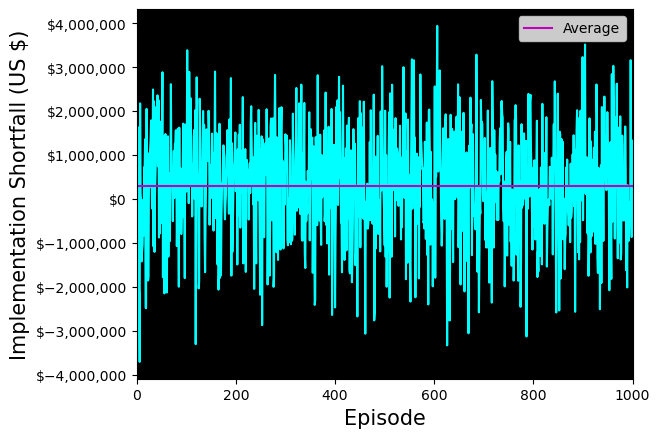

In [5]:
# plt.plot(total_rewards, 'cyan', label='')   
plot_shortfall_hist(shortfall_hist_normal)
eval_agent(trs=1000, agent=agent_normal)

## Decaying Gaussian Noise

In [17]:
from noise import DecayingGaussianNoise
# Create simulation environment
env = sca.MarketEnvironment()

action_size = env.action_space_dimension()
state_size = env.observation_space_dimension()
random_seed = 0

# Set the parameters
lqt = 60
n_trades = 60
tr = 1e-6
episodes = 10000

decay_rate = (1/(episodes * n_trades))*np.log(0.01/0.2)

noise = DecayingGaussianNoise(action_size, 
                              seed=random_seed, 
                              initial_scale=0.2, 
                              final_scale=0.01,
                              decay_rate=decay_rate)
# Initialize Feed-forward DNNs for Actor and Critic models. 
agent_decay = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, noise=noise)



# Train the agent and get the shortfall history
shortfall_hist_decay, total_rewards = train_agent(env, agent_decay, lqt, n_trades, tr, episodes)

Episode [100/10000]	Average Shortfall: $239,671.00
Episode [200/10000]	Average Shortfall: $289,291.53
Episode [300/10000]	Average Shortfall: $421,176.54
Episode [400/10000]	Average Shortfall: $216,793.65
Episode [500/10000]	Average Shortfall: $167,608.08
Episode [600/10000]	Average Shortfall: $346,185.83
Episode [700/10000]	Average Shortfall: $415,149.55
Episode [800/10000]	Average Shortfall: $254,874.91
Episode [900/10000]	Average Shortfall: $115,784.17
Episode [1000/10000]	Average Shortfall: $311,313.03
Episode [1100/10000]	Average Shortfall: $416,339.54
Episode [1200/10000]	Average Shortfall: $513,514.17
Episode [1300/10000]	Average Shortfall: $253,226.52
Episode [1400/10000]	Average Shortfall: $318,647.92
Episode [1500/10000]	Average Shortfall: $485,384.62
Episode [1600/10000]	Average Shortfall: $256,405.85
Episode [1700/10000]	Average Shortfall: $214,763.07
Episode [1800/10000]	Average Shortfall: $162,509.27
Episode [1900/10000]	Average Shortfall: $103,095.05
Episode [2000/10000]	

Average Implementation Shortfall: $264,939.85
Standard Deviation of the Implementation Shortfall: $1,298,343.10


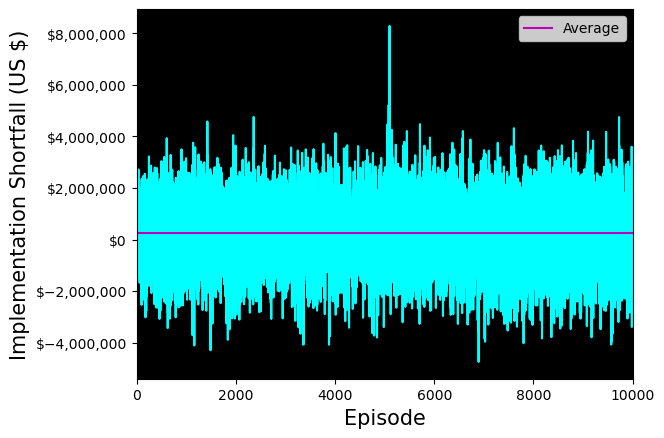

Average Implementation Shortfall: $267,395.21
Standard Deviation of the Implementation Shortfall: $1,202,013.17


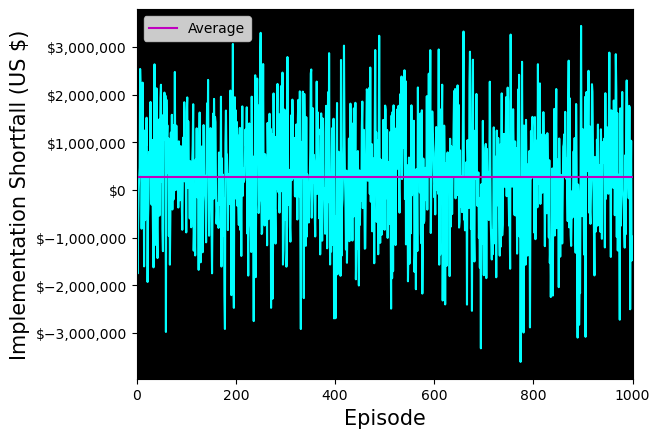

In [19]:
plot_shortfall_hist(shortfall_hist_decay)
eval_agent(trs=1000, agent=agent_decay)

# Todo

The above code should provide you with a starting framework for incorporating more complex dynamics into our model. Here are a few things you can try out:

- Incorporate your own reward function in the simulation environmet to see if you can achieve a expected shortfall that is better (lower) than that produced by the Almgren and Chriss model.


- Experiment rewarding the agent at every step and only giving a reward at the end.


- Use more realistic price dynamics, such as geometric brownian motion (GBM). The equations used to model GBM can be found in section 3b of this [paper](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1705&context=aabfj)


- Try different functions for the action. You can change the values of the actions produced by the agent by using different functions. You can choose your function depending on the interpretation you give to the action. For example, you could set the action to be a function of the trading rate.


- Add more complex dynamics to the environment. Try incorporate trading fees, for example. This can be done by adding and extra term to the fixed cost of selling, $\epsilon$.

# DONE:

#### **Task 1**
Incorporate your own reward function in the simulation environmet to see if you can achieve a expected shortfall that is better (lower) than that produced by the Almgren and Chriss model.

**Answer:**
Achieved a lower expected shortfall than the Almgren and Chriss model by using a reward function that penalizes the agent using implementation shortfall

#### **Task 2**
Experiment rewarding the agent at every step and only giving a reward at the end.

**Answer:**
Experimented with rewarding the agent at every step and only giving a reward at the end. The agent learns better when recieves reward at every step, but as we trying to minimize the implementation shortfall, the reward at the end is more meaningful in many cases. Though rewarding at every step can help the agent learn faster.


##### Reward 1 per step

```python 
# Reward 1  per step
#  New reward components
currentUtility = self.compute_utility(self.shares_remaining)
cost_reduction = (self.prevUtility.E - currentUtility.E)/(abs(self.prevUtility.E)+ 1)
variance_reduction = (self.prevUtility.V - currentUtility.V)/(abs(self.prevUtility.V) + 1)
self.prevUtility = currentUtility

# Balanced reward
reward = (0.7 * cost_reduction) + (0.3 * variance_reduction)

# Clip rewards for stability
reward = np.clip(reward, -2, 2)
```

###### Reward  at the end
```python
##### Reward 2 at the end
# reward in other steps
reward =  0.0
# Calculate the implementation shortfall
info.implementation_shortfall  = self.total_shares * self.startingPrice - self.totalCapture

# Add implementation shortfall to the reward
log_term = np.log(1 + abs(info.implementation_shortfall)) * np.sign(info.implementation_shortfall)

reward += -log_term  # np.clip(log_term, -10, 10)   
```


###### More Complex Reward Function
```python
def complex_reward(self):
    current_utility = self.compute_utility(self.shares_remaining)
    
    # Immediate cost penalty
    cost_penalty = -abs(current_utility.E) / (self.total_shares * self.startingPrice)
    
    # Variance penalty
    variance_penalty = -self.llambda * current_utility.V / (self.total_shares**2 * self.singleStepVariance)
    
    # Time penalty (encourage faster execution)
    time_penalty = -0.1 * (self.k / self.num_n)
    
    # Liquidation bonus
    liquidation_bonus = 10.0 if self.shares_remaining <= 0 else 0
    
    reward = (cost_penalty + variance_penalty + time_penalty + liquidation_bonus) / 10
    
    # Clip final reward
    reward = np.clip(reward, -1, 1)

    return reward
```


#### **Task 3**
Use more realistic price dynamics, such as geometric brownian motion (GBM). The equations used to model GBM can be found in section 3b of this [paper](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1705&context=aabfj)

```python
 def geometric_brownian_motion(self, current_price, mu=0.0):
        """
        Price evolves by: S_{t+1} = S_t * exp( (mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z ).
    
        Here:
        - mu  : drift (you can set it to 0 if you want “zero-drift”),
        - sigma = self.dpv  (daily percentage volatility),
        - dt   : can be 1 day if each step is 1 day, or self.tau if you're modeling fraction-of-day steps.
        """
        # For a daily step, dt = 1. Or if each action is 1/60th of a day, dt = self.tau.
        dt = self.tau  # or self.tau, depending on how you interpret time in your simulation
        sigma = self.dpv  # daily volatility in *log-returns*

        Z = random.normalvariate(0, 1)
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z

        return current_price * np.exp(drift + diffusion)
```

#### Task 4
Try different functions for the action. You can change the values of the actions produced by the agent by using different functions. You can choose your function depending on the interpretation you give to the action. For example, you could set the action to be a function of the trading rate.

**Answer:**
```python
def trading_rate_action(self, action):
    # If you have TOTAL_SHARES to sell over D days:
    # On average, you'd need (TOTAL_SHARES / D) shares/day.
    # You could allow the agent to go up to some factor times that average.
    factor = 2.0  # let the agent trade twice as fast as the "average pace"
    max_rate = factor * (self.total_shares / self.num_n)
    return max_rate * action
```

#### Task 5
Add more complex dynamics to the environment. Try incorporate trading fees, for example. This can be done by adding and extra term to the fixed cost of selling, $\epsilon$.

**Answer:**
```python
TRADING_FEE = 0.05                        # Fixed trading fee per share traded
EPSILON = BID_ASK_SP / 2  + TRADING_FEE   # Fixed Cost of Selling, Updated to include trading fee 
```

*Temporary Impact Calculation*: The temporary price impact now inherently accounts for trading fees through the updated EPSILON, which increases the fixed cost component of selling shares.

*Implementation Shortfall*: The total revenue (totalCapture) naturally decreases due to higher temporary impacts from the adjusted ε, reflecting the inclusion of fees in execution costs.

*Utility Calculations*: Expected shortfall (E) and utility (E + λV) automatically incorporate trading fees as part of the enhanced ε term, ensuring the agent optimizes while considering these costs.

**Answer2:** 
```python
TRADING_FEE_PERCENT = 0.001  # 0.1% fee on trade value (new parameter)


 # Apply percentage fee to executed price
fee_amount = TRADING_FEE_PERCENT * info.exec_price * info.share_to_sell_now
self.totalCapture += (info.share_to_sell_now * info.exec_price) - fee_amount

# New: Expected percentage fee cost (using starting price as approximation)
percentage_fee_cost = TRADING_FEE_PERCENT * self.startingPrice * sharesToSell
    
return permanent_impact_cost + spread_cost + temp_impact_cost + percentage_fee_cost
```